In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
import copy

In [3]:
data = pd.read_csv("drive/Shareddrives/CV_videos/preprocessed_270_frames_2_subsampled.csv", header=None)
# print(data)
# data[10260] = np.where(data[10260] == 12, 11, data[10260])
# data[10260] = np.where(data[10260] == 13, 12, data[10260])
# data[10260] = np.where(data[10260] == 14, 13, data[10260])
# print(data)

In [4]:
if (data == 0).all(axis=1).any():
  print("yes")

data.iloc[:, :-1] /= data.iloc[:, :-1].max().max()

In [5]:
if (data == float('nan')).all(axis=1).any():
  print("yes")

In [6]:
data
value_counts = data.iloc[:, -1].value_counts()

# print value counts
print(value_counts)


2.0     128
0.0     124
8.0     112
7.0     101
12.0     99
3.0      95
5.0      92
6.0      92
10.0     89
9.0      86
1.0      81
4.0      80
11.0     51
13.0     37
Name: 10260, dtype: int64


In [7]:
num_classes = len(np.unique(data.iloc[:,-1]))
# print(np.unique(data.iloc[:,-1]))
# print(data.iloc[:,-1])


print("num classes: ", num_classes)
input_dim = data.shape[1] - 1

X = data.iloc[:,:-1]
y = data.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0, stratify=y_train)

num classes:  14


In [8]:
# Detect if GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
train_data = np.array(X_train.join(y_train))
val_data = np.array(X_val.join(y_val))
test_data = np.array(X_test.join(y_test))

class MyDataset(Dataset):
    def __init__(self, data, device):
        self.features = torch.Tensor(data[:, :-1]).to(device)
        self.labels = torch.Tensor(data[:, -1]).type(torch.LongTensor).to(device)
    
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        return x, y
    
    def __len__(self):
        return len(self.labels)

train_data = MyDataset(train_data, device)
val_data = MyDataset(val_data, device)
test_data = MyDataset(test_data, device)

In [56]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # 5*5 from image dimension
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

import torch
import torch.nn as nn

class ResidualFCBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.0):
        super(ResidualFCBlock, self).__init__()
        
        self.fc1 = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(out_features, out_features)
        
        # If input and output shapes are not the same, add an identity shortcut
        if in_features != out_features:
            self.shortcut = nn.Linear(in_features, out_features)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = x
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        x += self.shortcut(identity)
        x = self.relu(x)
        
        return x


class Net2(nn.Module):
    def __init__(self, dropout):
        super(Net2, self).__init__()
        self.layers = nn.Sequential(
            ResidualFCBlock(input_dim, 4096, dropout_prob=dropout),
            # nn.Linear(input_dim, 4096),
            nn.BatchNorm1d(4096),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),
            
            # nn.Linear(4096, 2048),
            # nn.BatchNorm1d(2048),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),
            
            ResidualFCBlock(4096, 4096, dropout_prob=dropout),
            # nn.Linear(2048, 1024),
            nn.BatchNorm1d(4096),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),

            # nn.Linear(1024, 256),
            # nn.BatchNorm1d(256),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),

            ResidualFCBlock(4096, 256, dropout_prob=dropout),
            # nn.Linear(256, 128),
            nn.BatchNorm1d(256),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),

            ResidualFCBlock(256, 256, dropout_prob=dropout),
            # nn.Linear(128, 64),
            nn.BatchNorm1d(256),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),

            # nn.Linear(64, 32),
            # nn.BatchNorm1d(32),
            # nn.ReLU(),
            # nn.Dropout(p=0.3),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 14)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


model1 = Net1()
model2 = Net2(dropout=0.1)
model3 = Net3()
model4 = Net4()

In [57]:
batch_size = 32
num_epochs = 200
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [58]:
for b, (i, s) in enumerate(trainloader):
  if (torch.isnan(i)).sum():
    print(b, i)

In [59]:
loss_function = nn.CrossEntropyLoss()

model = model2
model_name = "model2"
params_to_update = model.parameters()
learning_rate = 0.001

# Observe that all parameters are being optimized
optimizer_ffn = optim.AdamW(params_to_update, lr=learning_rate)
scheduler_ffn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ffn, 'min', factor=0.5, patience=10, threshold=0.001)

In [60]:
reg_lambda = 0.0005

In [61]:
def calculate_loss(pred, labels, reg_lambda=0.01):
  loss = F.cross_entropy(pred, labels)
  l2_reg = torch.tensor(0.).to(device)
  for param in model.parameters():
    l2_reg += torch.norm(param, p=2)**2 +  torch.norm(param, p=1)
  return reg_lambda*l2_reg + loss

In [62]:
def train_ffn(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer, device: torch.device, silent: bool = True, reg_lambda=0.01):
    model.train()
    ground_truth = []
    predictions = []
    losses = []
    report_interval = 50

    running_loss = 0
    last_loss = 0
    correct = 0 
    total = 0
    
    for i, (data, labels) in enumerate(loader):
        optimizer.zero_grad()
        data = data.to(device)
        if torch.isnan(data).sum():
          print(i, data)
          nan_indices = torch.where(torch.isnan(data))[0]

          for j in nan_indices:
            start = max(0, j - 2)
            end = min(len(data), j + 3)
            print(f"NaN at index {j}, values [{start}:{end}]: {data[start:end]}")
          raise Exception("Issue")
        labels = labels.to(device)
        pred = model(data)
        loss = calculate_loss(pred, labels, reg_lambda)
        _, predicted = torch.max(pred.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        if not silent and i > 0 and i % report_interval == 0:
            print(
                "\t[%06d/%06d] Loss: %f"
                % (i, len(loader), np.mean(losses[-report_interval:]))
        )


    return np.mean(losses), correct / total

In [104]:
best_vloss = np.inf
best_model_wts = dict()

av_loss_per_epoch = []
av_val_loss_per_epoch = []
model.to(device)
print(model)
model_path = "best_model_so_far"

for i in range(num_epochs):
    print('EPOCH {}:'.format(i + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss, accuracy = train_ffn(model, trainloader, optimizer_ffn, device, reg_lambda=reg_lambda)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    iter = 0
    correct_val_data = 0
    total_val_data = 0
    with torch.no_grad():
        for j, vdata in enumerate(valloader):
            val_inputs, val_labels = vdata
            val_pred = model(val_inputs)
            vloss = calculate_loss(val_pred, val_labels, reg_lambda)
            validation_loss = vloss.item()
            running_vloss = running_vloss + vloss
            iter += 1
            _, v_predicted = torch.max(val_pred.data, 1)
            correct_val_data += (v_predicted == val_labels).sum().item()
            total_val_data += val_labels.size(0)

    avg_vloss = running_vloss / (iter + 1)
    av_loss_per_epoch.append(avg_vloss)

    print('Loss: train {} valid {} learning_rate {}'.format(avg_loss, avg_vloss, optimizer_ffn.param_groups[0].get('lr')))
    print('Accuracy: train {} valid {}'.format(accuracy, correct_val_data / total_val_data))

    scheduler_ffn.step(avg_vloss)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), model_path)
    if correct_val_data / total_val_data > 0.4:
        break


Net2(
  (layers): Sequential(
    (0): ResidualFCBlock(
      (fc1): Linear(in_features=10260, out_features=4096, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (fc2): Linear(in_features=4096, out_features=4096, bias=True)
      (shortcut): Linear(in_features=10260, out_features=4096, bias=True)
    )
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ResidualFCBlock(
      (fc1): Linear(in_features=4096, out_features=4096, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (fc2): Linear(in_features=4096, out_features=4096, bias=True)
      (shortcut): Identity()
    )
    (3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ResidualFCBlock(
      (fc1): Linear(in_features=4096, out_features=256, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (fc2): Li

KeyboardInterrupt: ignored

In [105]:
import os 
import datetime
trained_model_name = str(model_name) + "_b" + str(batch_size) + "_ep" + str(num_epochs) + "_lr" + str(learning_rate) + "_scheduling_onemax"
FOLDER_NAME = "drive/Shareddrives/CV_videos/results_training_NN/FFN/" + trained_model_name

if os.path.isdir(FOLDER_NAME):
  FOLDER_NAME = "drive/Shareddrives/CV_videos/results_training_NN/FFN/" + trained_model_name + "_" + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
os.mkdir(FOLDER_NAME)


In [106]:
PATH_TO_SAVE_CLREPORT = FOLDER_NAME + "/classification_report.csv"
PATH_TO_SAVE_VALACCURACY = FOLDER_NAME + "/validation_accuracy_per_epoch.csv"
PATH_TO_SAVE_TESTACC = FOLDER_NAME + "/final_test_accuarcy.csv"
PATH_TO_SAVE_CONFUSION = FOLDER_NAME + "/confusion_matrix.csv"

outputs:  tensor([[ 5.5910e-01,  2.4551e+00, -1.2199e+00,  2.2406e+00,  2.3623e+00,
         -2.0303e+00,  1.0565e+00, -2.5577e+00, -3.4979e-01, -1.7804e+00,
         -1.4257e+00,  2.0165e+00, -5.9455e-01, -2.9370e-02],
        [-3.8187e+00,  3.2533e-03, -3.0592e+00, -4.2899e+00, -3.1240e+00,
          1.8000e+00, -3.6873e+00,  6.0443e+00,  2.0054e+00,  3.7866e+00,
          4.0125e+00,  1.7149e+00, -2.8678e+00, -2.1129e+00],
        [ 1.5494e+00,  4.8042e-01, -2.1656e+00, -8.0715e-01, -2.2481e+00,
          1.4042e+00, -4.6662e-01,  2.6315e+00,  2.1816e-01,  4.7634e-01,
          2.7202e+00,  8.6366e-01, -3.2006e+00, -1.7979e+00],
        [-3.3697e+00, -1.6246e+00, -2.3786e+00, -1.7010e+00, -3.3649e+00,
         -4.5617e-01, -1.1523e+00,  6.6026e+00,  3.4468e+00,  2.4078e+00,
          3.7487e+00, -1.5018e+00, -1.3892e+00, -2.6470e+00],
        [-6.5475e-01, -5.1098e-01, -7.3160e-01, -1.8459e+00, -2.8829e+00,
          4.5665e+00, -1.3594e+00,  1.1621e+00, -1.5910e+00,  2.6786e+00,
  

(2.98080734048356, 0.2902208201892745)

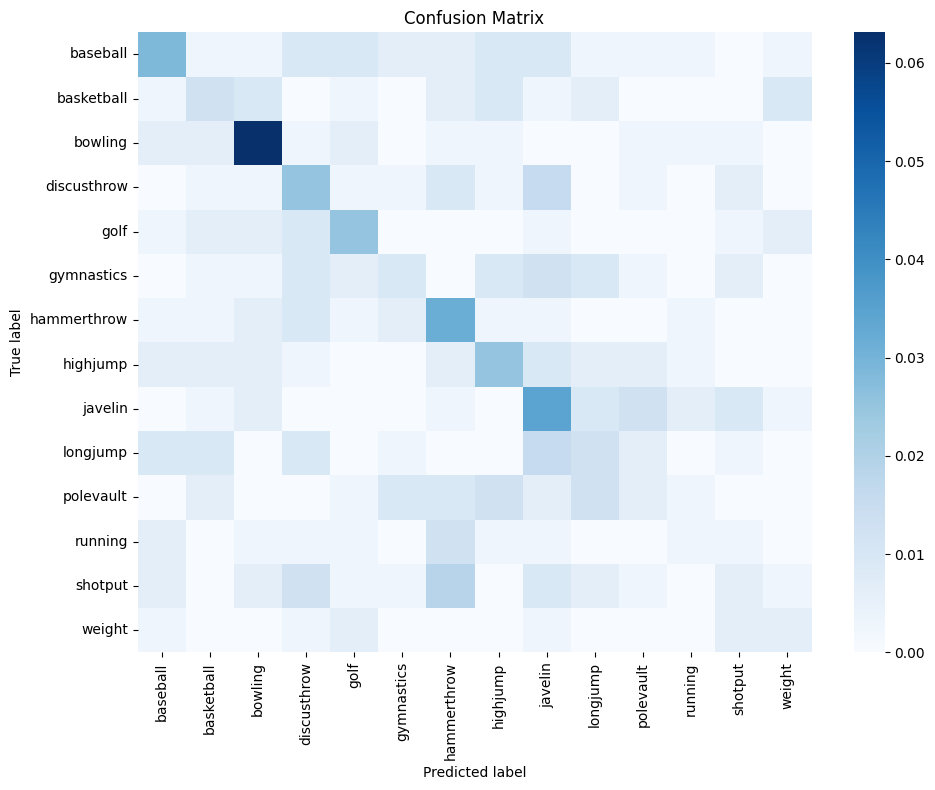

In [107]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate(model, dataloader, loss_fn, device, best_so_far=False):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables for tracking the loss and accuracy
    total_loss = 0
    correct = 0
    total = 0
    
    all_pred = []
    all_true = []

    # Disable gradient computations for efficiency
    with torch.no_grad():
        # Loop through the data in the dataloader
        for batch_idx, (data, target) in enumerate(dataloader):
            # Move the data and target tensors to the device
            data, target = data.to(device), target.to(device)
            
            # Forward pass the data through the model
            output = model(data)
            print("outputs: ", output)
            # Compute the loss between the model's predictions and the target
            loss = loss_fn(output, target)
            
            # Update the total loss
            total_loss += loss.item() * target.size(0)
            
            # Compute the accuracy of the model's predictions
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            all_pred.append(predicted)
            all_true.append(target)
            
    
    # Compute the average loss and accuracy over the entire dataset
    avg_loss = total_loss / total
    accuracy = correct / total
    
    y_all_pred = torch.cat(all_pred).cpu().numpy()
    y_all_true = torch.cat(all_true).cpu().numpy()

    # all_pred = [a.cpu().numpy().tolist() for a in all_pred]
    # all_true = [a.cpu().numpy().tolist() for a in all_true]
    # print(y_all_pred)
    # print(y_all_true)

    class_labels = ['baseball', 'basketball', 'bowling', 'discusthrow', 'golf', 'gymnastics', 'hammerthrow', 'highjump', 'javelin', 'longjump', 'polevault', 'running', 'shotput', 'weight']
    # class_labels = None
    cm = confusion_matrix(y_true=y_all_true, y_pred=y_all_pred, normalize='all', labels=None)
    save_confusion_path = PATH_TO_SAVE_CONFUSION
    if best_so_far:
      save_confusion_path = save_confusion_path.replace(".csv", "_best_so_far.csv")
    np.savetxt(PATH_TO_SAVE_CONFUSION, cm, delimiter=",")

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='.3f', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()

    # Save the plot to a file
    fig.savefig(PATH_TO_SAVE_CONFUSION + ".png")

    clsf_report = pd.DataFrame(classification_report(y_true = y_all_true, y_pred = y_all_pred, output_dict=True, target_names=class_labels)).transpose()
    save_clreport_path = PATH_TO_SAVE_CLREPORT
    if best_so_far:
      save_clreport_path = save_clreport_path.replace(".csv", "_best_so_far.csv")
    clsf_report.to_csv(save_clreport_path, index= True)
    

    # Print the results
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        avg_loss, correct, total, 100. * accuracy))
    
    return avg_loss, accuracy


avg_loss, accuracy = evaluate(model, testloader, F.cross_entropy, device)
avg_loss, accuracy



outputs:  tensor([[ 0.6692,  2.0755, -1.2884,  2.0716,  2.0609, -1.8591,  1.1031, -2.0328,
         -0.1796, -1.2624, -1.3855,  1.7375, -0.6144, -0.1826],
        [-4.0049, -0.4923, -3.1480, -4.5412, -3.7325,  2.0220, -3.7982,  6.3682,
          2.1883,  4.0882,  4.2095,  1.8198, -2.8873, -2.2140],
        [ 1.2033,  0.2676, -2.3829, -1.0420, -2.4428,  1.2442, -0.7549,  3.1849,
          0.7409,  0.7327,  2.9667,  0.4164, -3.1696, -1.6852],
        [-3.2459, -1.6214, -2.6110, -2.0962, -3.9382, -0.3474, -1.4592,  7.1784,
          3.8666,  2.7440,  3.6222, -1.7333, -1.5310, -2.6832],
        [-0.9803, -0.5615, -0.9285, -2.3649, -3.1708,  4.7198, -1.6954,  1.7731,
         -1.2853,  3.3567,  3.0772,  2.8765, -2.1750, -3.5464],
        [ 1.4978,  3.0573, -2.8368, -0.8052, -1.3525, -2.7943,  3.0597,  0.5642,
          2.9021,  0.2112, -4.3575, -1.6052, -0.0548,  0.1580],
        [-0.7409, -1.0509, -0.9092, -1.9345, -4.4385,  5.9997, -1.4933,  2.9407,
         -5.1372,  1.9283,  5.3203, -3.

(2.9983480992001312, 0.28391167192429023)

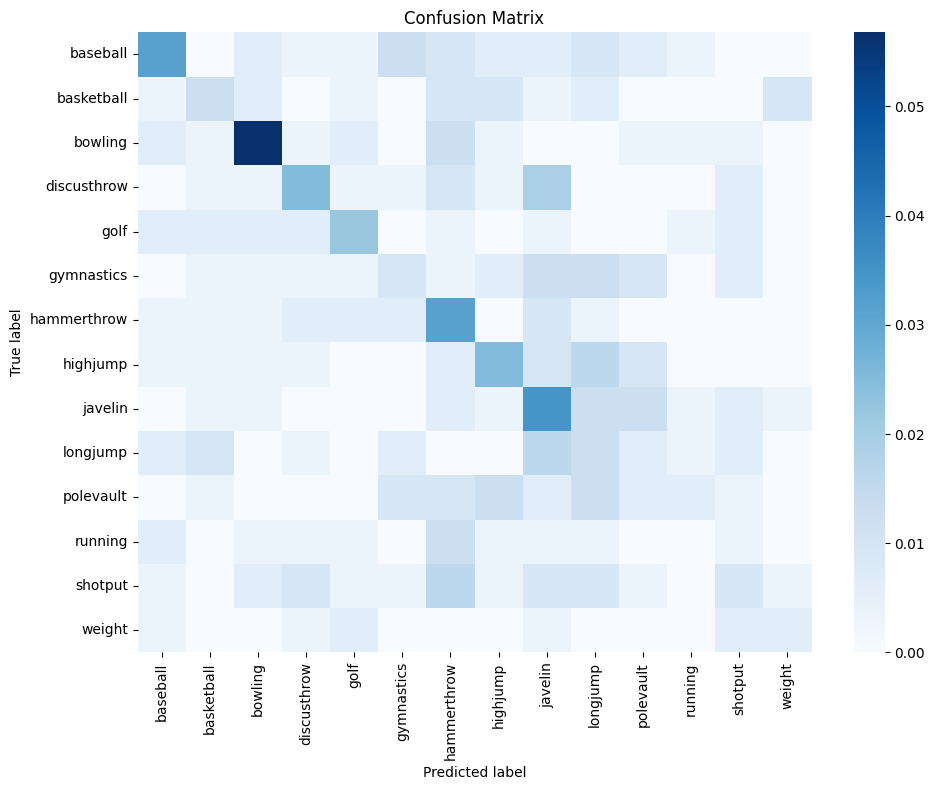

In [108]:
best_model_wts = torch.load(model_path)
model.load_state_dict(best_model_wts)
avg_loss, accuracy = evaluate(model, testloader, F.cross_entropy, device, best_so_far=True)
avg_loss, accuracy